# **Prototyping**

In this notebook, we will explore the nature of our data, first by using the skin cancer dataset from kaggle.

In [1]:
%matplotlib inline

import kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from pathlib import Path
from glob import glob
import seaborn as sns

from PIL import Image

np.random.seed(123)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import itertools

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p ../data/raw --unzip -o -q

## **Step 2: Making Dictionary of images and labels**

In [3]:
BASE_SKIN_DIR = Path( "../data/raw/HAM10000_images" )
imageid_path_dict = { os.path.splitext( os.path.basename( f ) )[ 0 ] : f
                     for f in list( BASE_SKIN_DIR.rglob( "*.jpg" ) ) }

skin_lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
# class SkinLesionDataset( Dataset ):
#     def __init__( self, csv_file, root_dir, transform=None ):
#         self.transform = transform

#         self.root_dir = root_dir

#         # Setup the DataFrame
#         self.df = pd.read_csv( csv_file )

#         # Add additional columns to the DataFrame
#         ## THIS LINE RELIES ON A VARIABLE DEFINED OUTSIDE THE CLASS
#         self.df[ 'path' ] = self.df[ 'image_id' ].map( imageid_path_dict.get )
#         self.df[ 'cell_type' ] = self.df[ 'dx' ].map( skin_lesion_type_dict.get )
#         self.df[ 'cell_type_idx' ] = self.df[ 'cell_type' ].factorize()[ 0 ]

#         # Splitting the DataFrame into Train and Test Sets
#         # features = self.df.drop( columns=[ 'cell_type_idx' ], axis=1 )
#         # target = self.df[ 'cell_type_idx' ]
#         # train_df, test_df = train_test_split( self.df, test_size=0.2, random_state=1234, stratify=self.df[ 'cell_type_idx' ] )

#         # Handling Missing Values with Imputation
#         L1_series = self.df.groupby( [ 'sex', 'dx', 'dx_type' ] )[ 'age' ].mean().transform( lambda x: round( x, 0 ) )
#         L2_series = self.df.groupby( [ 'sex', 'dx' ] )[ 'age' ].mean().transform( lambda x: round( x, 0 ) )
#         L3_series = self.df.groupby( [ 'sex' ] )[ 'age' ].mean().transform( lambda x: round( x, 0 ) )
        

#         while self.df.age.isnull().sum() > 0:
#             self.df[ 'age' ] = self.df.groupby( [ 'sex', 'dx', 'dx_type' ] )[ 'age' ].transform( lambda x: x.fillna( round( x.mean( numeric_only = True ), 0 ) ) )
#             if self.df.age.isnull().sum() > 0:
#                 self.df[ 'age' ] = self.df.groupby( [ 'sex', 'dx' ] )[ 'age' ].transform( lambda x: x.fillna( round( x.mean( numeric_only = True ), 0 ) ) )
#             if self.df.age.isnull().sum() > 0:
#                 self.df[ 'age' ] = self.df[ 'age' ].fillna( round( self.df[ 'age' ].mean( numeric_only = True ), 0 ) )

#     def __getitem__( self, idx ):
#         img_name = self.df.iloc[ idx ][ 'path' ]
#         image = Image.open( img_name ).convert( 'RGB' )
#         label = self.df.iloc[ idx ][ 'cell_type_idx' ]

#         if self.transform:
#             image = self.transform( image )

#         return image, label
    
#     def __len__( self ):
#         return len( self.df )

## **Step 3: Reading and Processing the Data**

In [5]:
skin_df = pd.read_csv( "../data/raw/HAM10000_metadata.csv" )

skin_df[ 'path' ] = skin_df[ 'image_id' ].map( imageid_path_dict.get )
skin_df[ 'cell_type' ] = skin_df[ 'dx' ].map( skin_lesion_type_dict.get )
skin_df[ 'cell_type_idx' ] = pd.Categorical( skin_df[ 'cell_type' ] ).codes

In [6]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\data\raw\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [7]:
train_df, test_df = train_test_split( 
    skin_df, test_size = 0.2, 
    random_state = 42, stratify = skin_df[ 'cell_type_idx' ] )

## **Step 4: Data Cleansing**

In [8]:
train_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              52
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [9]:
train_df.loc[ train_df[ 'age' ].isnull(), : ]

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
9620,HAM_0003034,ISIC_0033187,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033187.jpg,Melanocytic nevi,4
9627,HAM_0001433,ISIC_0033735,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033735.jpg,Melanocytic nevi,4
972,HAM_0000983,ISIC_0033490,bkl,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033490.jpg,Benign keratosis-like lesions,2
9613,HAM_0001118,ISIC_0033332,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033332.jpg,Melanocytic nevi,4
9616,HAM_0005439,ISIC_0033597,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033597.jpg,Melanocytic nevi,4
9386,HAM_0000698,ISIC_0031668,nv,consensus,NaN,male,foot,..\data\raw\HAM10000_images\ISIC_0031668.jpg,Melanocytic nevi,4
9615,HAM_0003696,ISIC_0032945,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0032945.jpg,Melanocytic nevi,4
9617,HAM_0002282,ISIC_0034045,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0034045.jpg,Melanocytic nevi,4
8555,HAM_0007278,ISIC_0032300,nv,histo,NaN,female,chest,..\data\raw\HAM10000_images\ISIC_0032300.jpg,Melanocytic nevi,4
9387,HAM_0000698,ISIC_0027431,nv,consensus,NaN,male,foot,..\data\raw\HAM10000_images\ISIC_0027431.jpg,Melanocytic nevi,4


In [10]:
train_df.groupby( [ 'dx_type' ] )[ 'age' ].mean().round( 0 )

dx_type
confocal     65.0
consensus    48.0
follow_up    49.0
histo        54.0
Name: age, dtype: float64

In [11]:
train_df.groupby( [ 'dx' ] )[ 'age' ].mean().round( 0 )

dx
akiec    66.0
bcc      67.0
bkl      64.0
df       52.0
mel      61.0
nv       46.0
vasc     50.0
Name: age, dtype: float64

In [12]:
test_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              5
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [13]:
test_df.loc[ test_df[ 'age' ].isnull(), : ]

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
9619,HAM_0003998,ISIC_0033809,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033809.jpg,Melanocytic nevi,4
9602,HAM_0004508,ISIC_0033628,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033628.jpg,Melanocytic nevi,4
9608,HAM_0000421,ISIC_0034080,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0034080.jpg,Melanocytic nevi,4
8410,HAM_0006706,ISIC_0031725,nv,histo,NaN,female,abdomen,..\data\raw\HAM10000_images\ISIC_0031725.jpg,Melanocytic nevi,4
9595,HAM_0007460,ISIC_0032578,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0032578.jpg,Melanocytic nevi,4


In [14]:
test_df.groupby( [ 'dx_type' ] )[ 'age' ].mean().round( 0 )

dx_type
confocal     63.0
consensus    48.0
follow_up    49.0
histo        55.0
Name: age, dtype: float64

In [15]:
test_df.groupby( [ 'dx' ] )[ 'age' ].mean().round( 0 )

dx
akiec    67.0
bcc      65.0
bkl      64.0
df       57.0
mel      61.0
nv       47.0
vasc     55.0
Name: age, dtype: float64

[Text(0.5, 1.0, 'Train Set : Stacked Histogram of Age Distribution by Sex'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

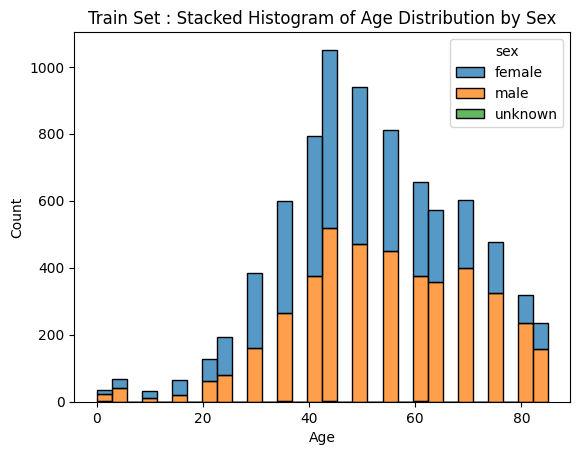

In [16]:
ax = sns.histplot( data=train_df, 
             x='age', 
             hue='sex', 
             multiple='stack', 
             bins=30 )

ax.set( title='Train Set : Stacked Histogram of Age Distribution by Sex',
       xlabel='Age', ylabel='Count' )

[Text(0.5, 1.0, 'Train Set : Stacked Histogram of Age Distribution by dx'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

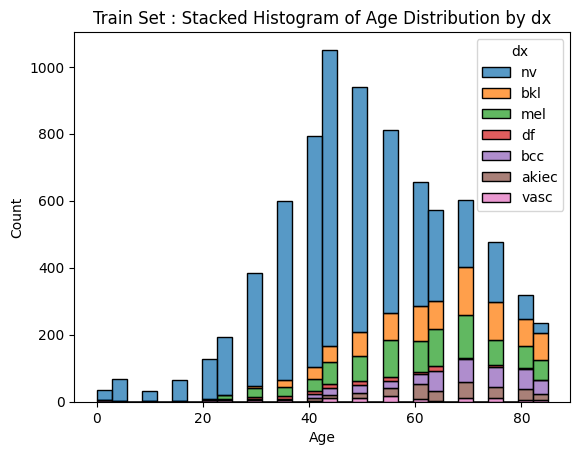

In [17]:
ax = sns.histplot( data=train_df, 
             x='age', 
             hue='dx', 
             multiple='stack', 
             bins=30 )

ax.set( title='Train Set : Stacked Histogram of Age Distribution by dx',
       xlabel='Age', ylabel='Count' )

[Text(0.5, 1.0, 'Test Set : Stacked Histogram of Age Distribution by Sex'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

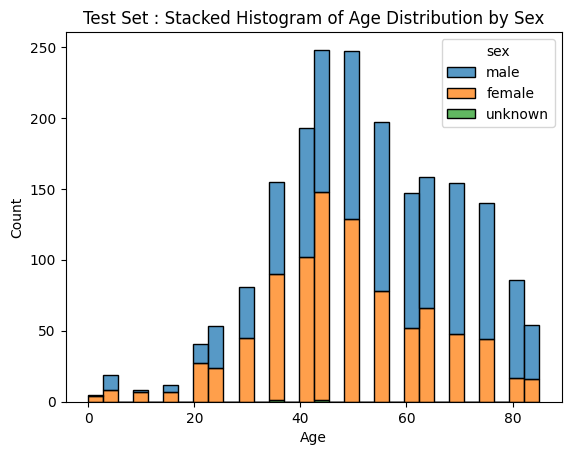

In [18]:
ax = sns.histplot( data=test_df, 
             x='age', 
             hue='sex', 
             multiple='stack', 
             bins=30 )

ax.set( title='Test Set : Stacked Histogram of Age Distribution by Sex',
       xlabel='Age', ylabel='Count' )

[Text(0.5, 1.0, 'Test Set : Stacked Histogram of Age Distribution by dx'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

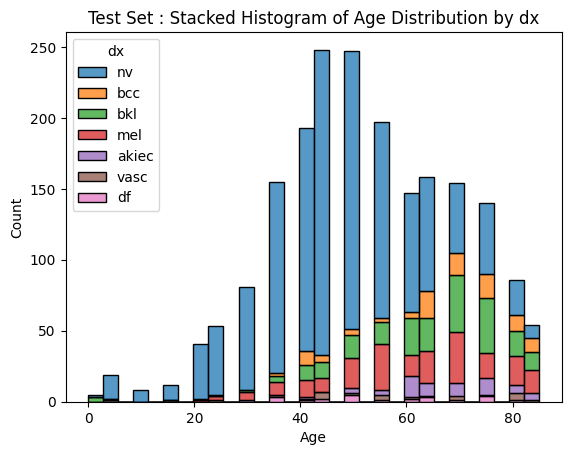

In [19]:
ax = sns.histplot( data=test_df, 
             x='age', 
             hue='dx', 
             multiple='stack', 
             bins=30 )

ax.set( title='Test Set : Stacked Histogram of Age Distribution by dx',
       xlabel='Age', ylabel='Count' )

In [20]:
train_L1_series = train_df.groupby( [ 'dx', 'dx_type' ] )[ 'age' ].transform( 'mean' ).round( 0 )
train_L2_series = train_df.groupby( [ 'dx' ] )[ 'age' ].transform( 'mean' ).round( 0 )
train_L3_series = train_df[ 'age' ].mean() + ( 2 * train_df[ 'age' ].std() ).round( 0 )

test_L1_series = test_df.groupby( [ 'dx', 'dx_type' ] )[ 'age' ].transform( 'mean' ).round( 0 )
test_L2_series = test_df.groupby( [ 'dx' ] )[ 'age' ].transform( 'mean' ).round( 0 )
test_L3_series = test_df[ 'age' ].mean() + ( 2 * test_df[ 'age' ].std() ).round( 0 )

In [21]:
train_df[ 'age_imputed' ] = train_df[ 'age' ].fillna( train_L1_series ).fillna( train_L2_series ).fillna( train_L3_series )
test_df[ 'age_imputed' ] = test_df[ 'age' ].fillna( test_L1_series ).fillna( test_L2_series ).fillna( test_L3_series )

[Text(0.5, 1.0, 'Train Set : Stacked Histogram of Age Distribution by Sex'),
 Text(0.5, 0, 'Age_Imputed'),
 Text(0, 0.5, 'Count')]

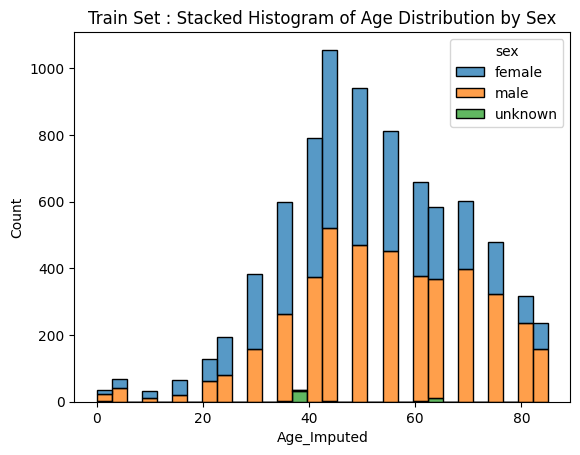

In [22]:
ax = sns.histplot( data=train_df, 
             x='age_imputed', 
             hue='sex', 
             multiple='stack', 
             bins=30 )

ax.set( title='Train Set : Stacked Histogram of Age Distribution by Sex',
       xlabel='Age_Imputed', ylabel='Count' )

[Text(0.5, 1.0, 'Train Set : Stacked Histogram of Age Distribution by dx'),
 Text(0.5, 0, 'Age_Imputed'),
 Text(0, 0.5, 'Count')]

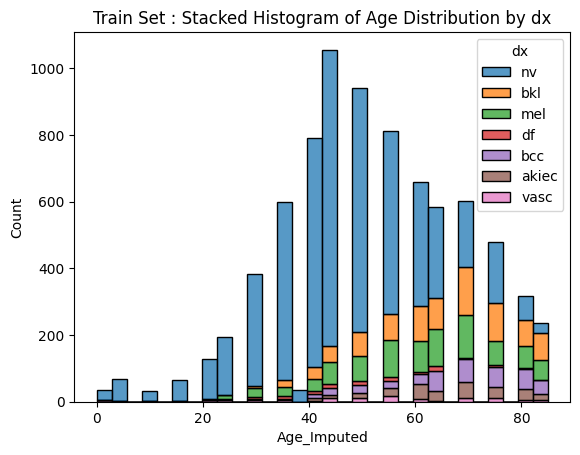

In [23]:
ax = sns.histplot( data=train_df, 
             x='age_imputed', 
             hue='dx', 
             multiple='stack', 
             bins=30 )

ax.set( title='Train Set : Stacked Histogram of Age Distribution by dx',
       xlabel='Age_Imputed', ylabel='Count' )

[Text(0.5, 1.0, 'Test Set : Stacked Histogram of Age Distribution by Sex'),
 Text(0.5, 0, 'Age_Imputed'),
 Text(0, 0.5, 'Count')]

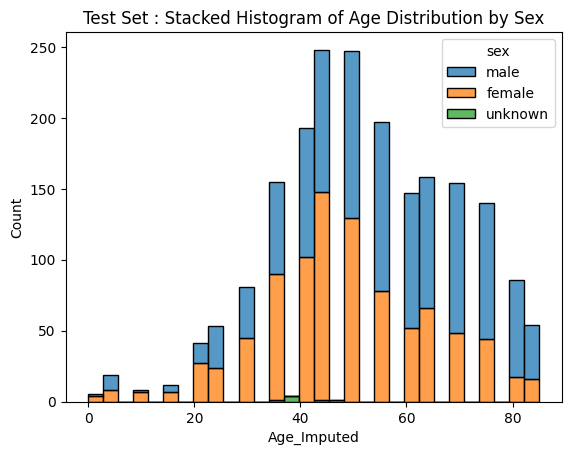

In [24]:
ax = sns.histplot( data=test_df, 
             x='age_imputed', 
             hue='sex', 
             multiple='stack', 
             bins=30 )

ax.set( title='Test Set : Stacked Histogram of Age Distribution by Sex',
       xlabel='Age_Imputed', ylabel='Count' )

[Text(0.5, 1.0, 'Test Set : Stacked Histogram of Age Distribution by dx'),
 Text(0.5, 0, 'Age_Imputed'),
 Text(0, 0.5, 'Count')]

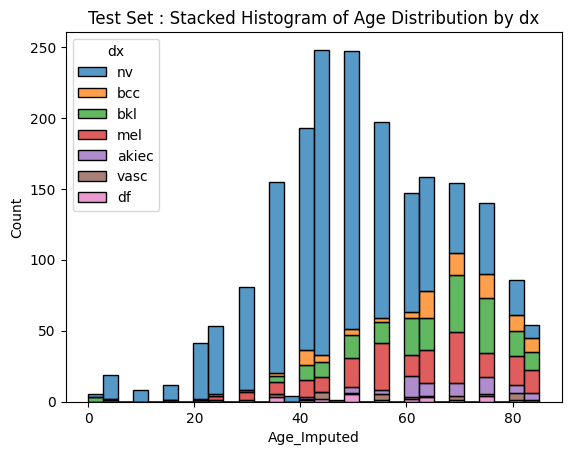

In [25]:
ax = sns.histplot( data=test_df, 
             x='age_imputed', 
             hue='dx', 
             multiple='stack', 
             bins=30 )

ax.set( title='Test Set : Stacked Histogram of Age Distribution by dx',
       xlabel='Age_Imputed', ylabel='Count' )

## **Step 5: Exploratory Data Analysis**

<Axes: title={'center': 'Count of Each Skin Cell Type'}, xlabel='Skin Cell Type', ylabel='Count'>

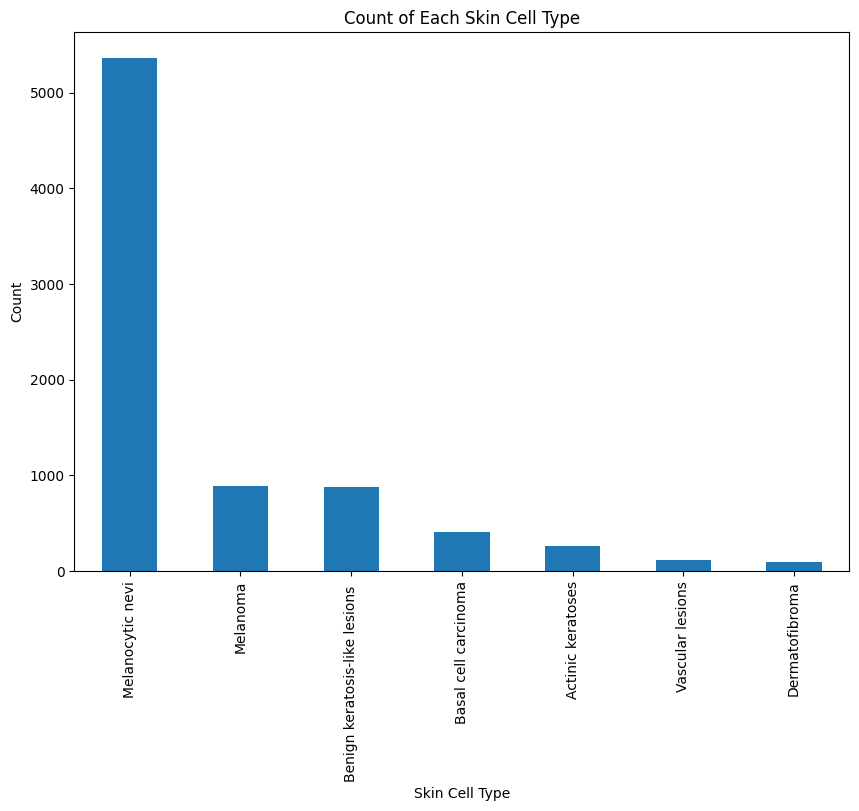

In [26]:
fig, ax1 = plt.subplots( 1, 1, figsize=( 10, 7 ) )
train_df[ 'cell_type' ].value_counts().plot( kind='bar', ax=ax1, title='Count of Each Skin Cell Type', 
                                                  xlabel='Skin Cell Type', ylabel='Count' )

<Axes: xlabel='dx_type'>

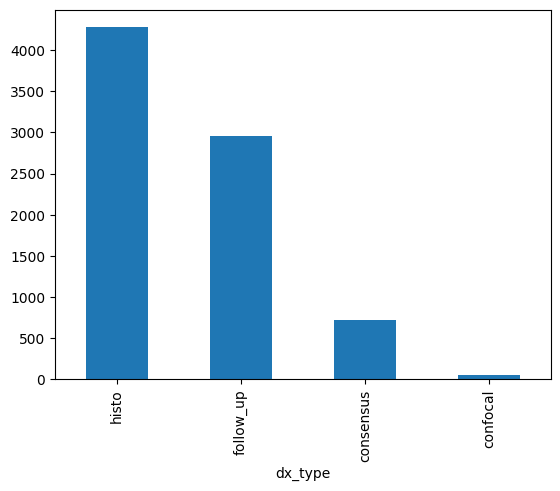

In [27]:
train_df[ 'dx_type' ].value_counts().plot( kind='bar' )

<Axes: xlabel='localization'>

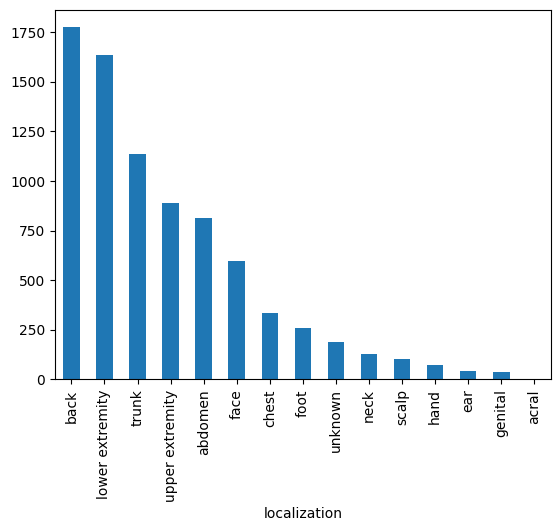

In [28]:
train_df[ 'localization' ].value_counts().plot( kind='bar' )

<Axes: >

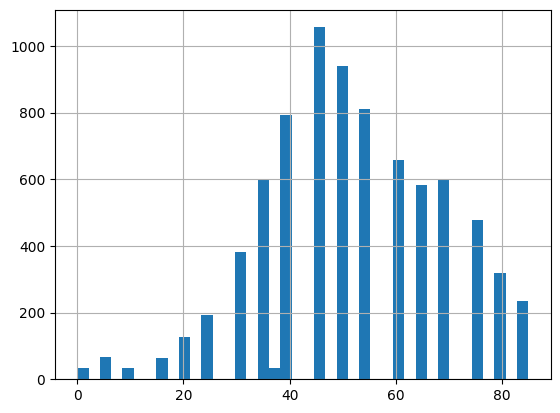

In [29]:
train_df[ 'age_imputed' ].hist( bins=40 )

<Axes: xlabel='age_imputed', ylabel='cell_type'>

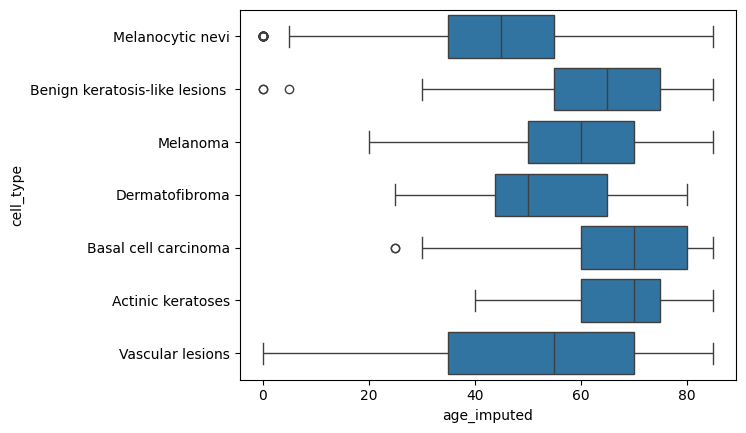

In [30]:
sns.boxplot( x='age_imputed', y='cell_type', data=train_df )

<Axes: title={'center': 'Count of Each Skin Cell Type'}, xlabel='Skin Cell Type', ylabel='Count'>

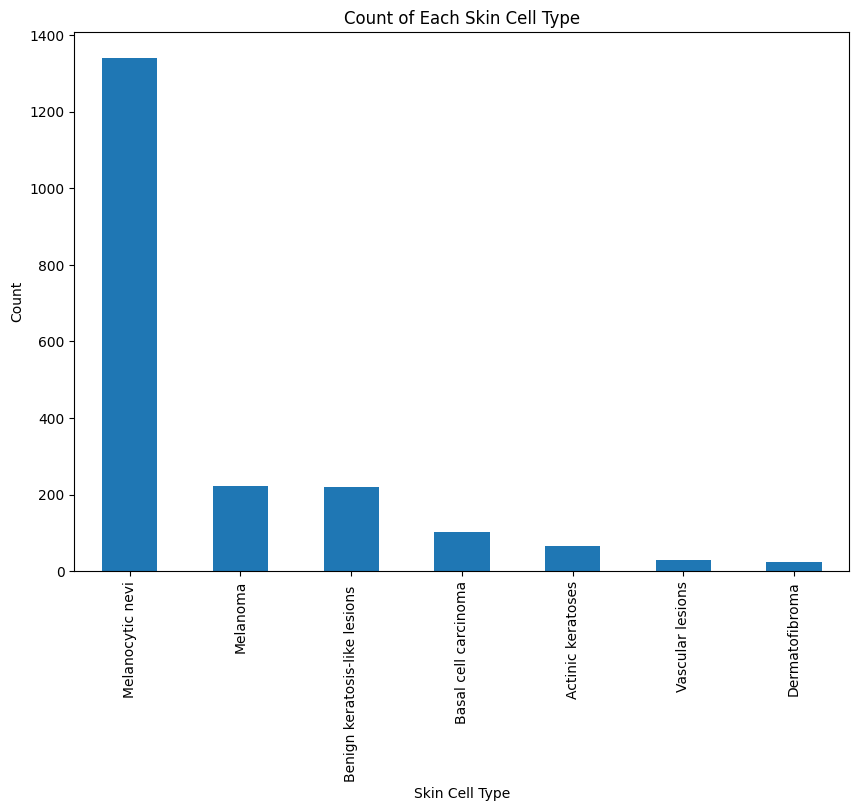

In [31]:
fig, ax1 = plt.subplots( 1, 1, figsize=( 10, 7 ) )
test_df[ 'cell_type' ].value_counts().plot( kind='bar', ax=ax1, title='Count of Each Skin Cell Type', 
                                                  xlabel='Skin Cell Type', ylabel='Count' )

<Axes: xlabel='dx_type'>

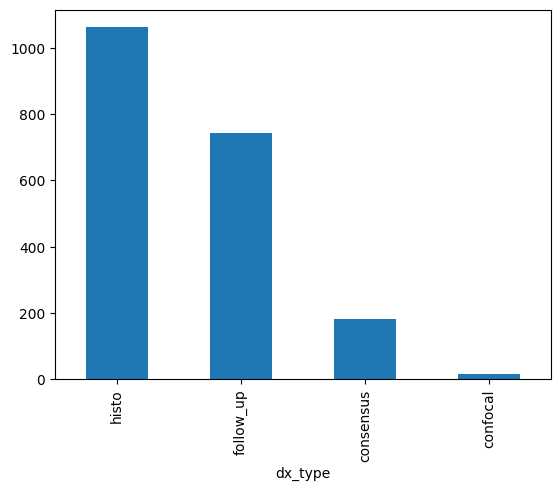

In [32]:
test_df[ 'dx_type' ].value_counts().plot( kind='bar' )

<Axes: xlabel='localization'>

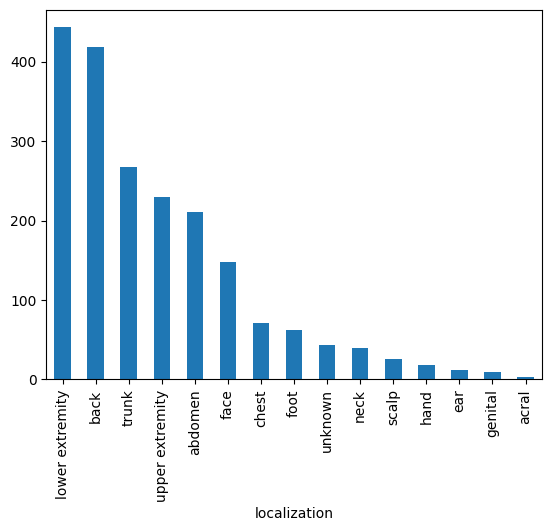

In [33]:
test_df[ 'localization' ].value_counts().plot( kind='bar' )

<Axes: >

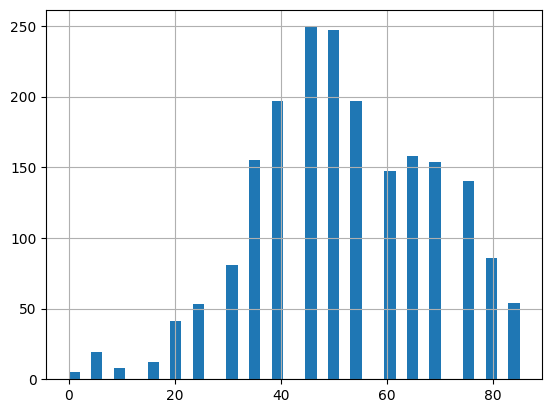

In [34]:
test_df[ 'age_imputed' ].hist( bins=40 )

<Axes: xlabel='age_imputed', ylabel='cell_type'>

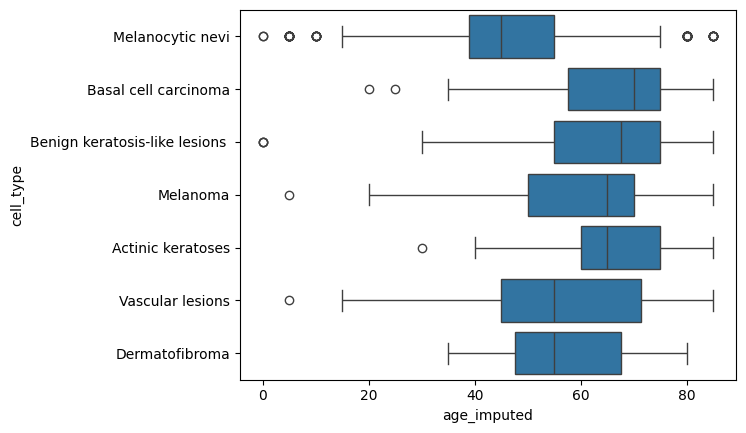

In [35]:
sns.boxplot( x='age_imputed', y='cell_type', data=test_df )

## **Step 6: Loading and Resizing of Images**

In [ ]:
test_impute_df[ 'image' ] = test_impute_df[ 'path' ].map(lambda x: np.asarray( Image.open( x ).resize( ( 100, 75 ) ) ) )

In [ ]:
test_impute_df.head()

Show sample of images from each cancer type

In [ ]:
n_samples = 5
fig, axes = plt.subplots( len( skin_lesion_type_dict ), n_samples, figsize = ( 4 * n_samples, 3 * len( skin_lesion_type_dict ) ) )

for n_axes, ( type_name, type_rows ) in zip( axes, test_impute_df.sort_values( [ 'cell_type' ] ).groupby( 'cell_type' ) ):
    n_axes[ 0 ].set_title( f"{ type_name }", fontsize = 16 )
    for ax, ( _, row ) in zip( n_axes, type_rows.sample( n_samples, random_state = 1234 ).iterrows() ):
        ax.imshow( row[ 'image' ] )
        ax.axis( 'off' )

if not os.path.exists( "../reports/figures/" ):
    os.makedirs( "../reports/figures/" )

fig.savefig( "../reports/figures/sample_skin_lesion_images.png", bbox_inches = 'tight', dpi = 300 )

In [ ]:
test_impute_df[ 'image' ].map( lambda x: x.shape ).value_counts()

In [ ]:
features = test_impute_df.drop( columns=[ 'cell_type_idx' ], axis=1 )
target = test_impute_df[ 'cell_type_idx' ]

## **Step 7: Train Test Split**

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split( features, target, test_size=0.2, random_state=1234, stratify=target )